## <Center> Classification with K-Nearest Neighbors
    
<Center><author> Zander Bonnet
    
<center><Date> Aug 14, 2024

I selected the Adult dataset from the UCI machine learning repository. Bary Becker extracted this data from the 1994 Census database. This data is ethically gathered as it is taken from a public survey and he sorted out any minors and elderly from the data. The parameters are that the individuals must be over 16 and under 100.

The data set contains a variety of factors that include their native country, race, gender, age, level of education, marital status, relationship to the submitter of information, occupation, and sector their occupation is in. The data also contains some numerical information like the amount of money have lost in capital losses, and if they haven't lost any it lists their capital gains. All of this data is taken so that we can relate it to their income. In the data, their income is represented by if they make more or less than 50 thousand dollars a year. This means we can use this data to make predictions on an individual's level of income.

In this case, we can use KNN to help classify someone's income level. KNN can accomplish this by taking input data and then calculating the distance, in this example, I will use Euclidean, between the input and every single point in the model. The algorithm then ranks all of the points by how ‘close’ they are and chooses the k nearest ones. In this example, I will be using 5 as the value of k. Once the algorithm has picked its k nearest neighbors it will make a prediction based on those neighbors. If the prediction is classification the model will choose the mode of the neighbors, and if the problem is regression then it will return the mean of the neighbors. Since the model is distance based the model runs under the assumption that similar points are actually close to each other and not random.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, roc_curve, auc

Matplotlib is building the font cache; this may take a moment.


In [3]:
adult = pd.read_csv('/Users/zanderbonnet/Desktop/GCU/DSC_540/Week_1/adult.csv')
adult.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [5]:
#drop data with missing values
cat = ['workclass', 'marital-status', 'occupation', 'relationship','race','native-country']
for x in cat:
    dr = np.where(adult[x]=='?')[0]
    if len(dr) > 0:
        adult = adult.drop(dr).reset_index(drop = True)

In [7]:
#Make cat names more friendly to work with
adult = adult.rename(columns ={'educational-num':'educational_num', 'marital-status':'marital_status',
                            'capital-gain':'capital_gain', 'capital-loss':'capital_loss',
                            'hours-per-week':'hours_per_week','native-country':'native_country'})

In [9]:
#Drop redundent features
adult = adult.drop('education', axis = 1)
adult = adult.drop('fnlwgt', axis = 1)

#Make gender numerical
adult['gender'] = adult['gender'].apply(lambda x: 1 if x == 'Male' else 0)

#Make responce numerical
adult['income'] = adult['income'].str.strip()
adult['income'] = adult['income'].apply(lambda x: 1 if x == '>50K' else 0 if x == '<=50K' else None)
adult.head()

,age,workclass,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,7,Never-married,Machine-op-inspct,Own-child,Black,1,0,0,40,United-States,0
1,38,Private,9,Married-civ-spouse,Farming-fishing,Husband,White,1,0,0,50,United-States,0
2,28,Local-gov,12,Married-civ-spouse,Protective-serv,Husband,White,1,0,0,40,United-States,1
3,44,Private,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,1,7688,0,40,United-States,1
4,34,Private,6,Never-married,Other-service,Not-in-family,White,1,0,0,30,United-States,0


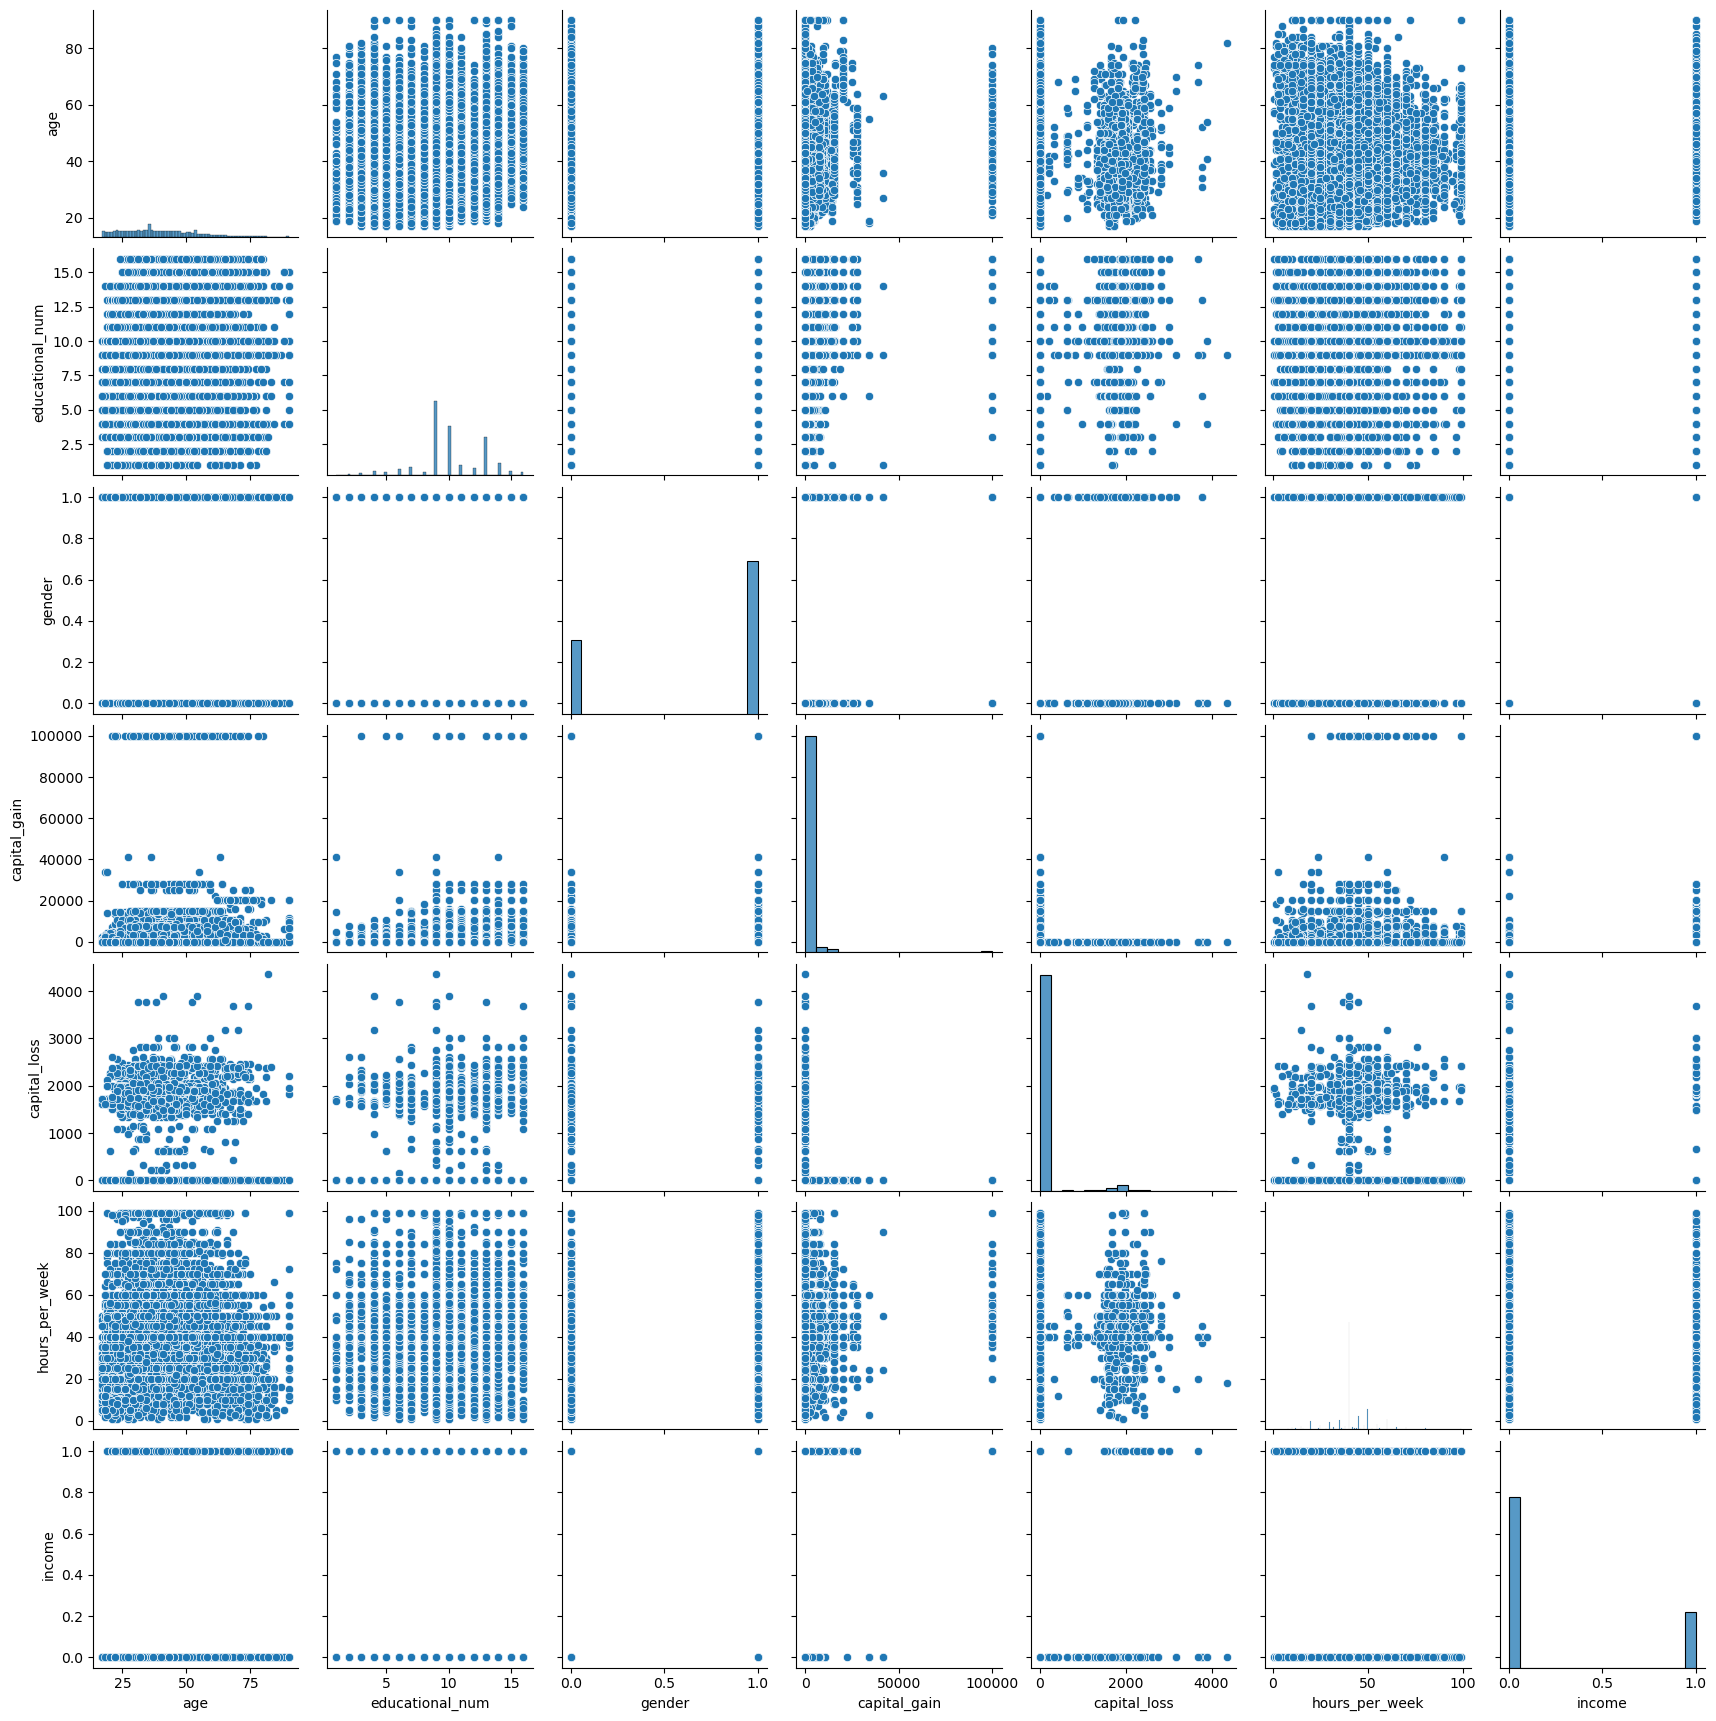

In [11]:
sns.pairplot(adult)
plt.show()

There do not appear to be any major outliers or anomalies in the data. One thing to note is that there is a difference in the size of the income groups, so when making predictions we need to check if the model is favoring one group over the other.

For the model to be able to calculate the distance between categorical variables we need to make dummy variables for all of the unique categorical responses. This will allow the algorithm to calculate numerical distances between them.

In [14]:
#make dummy variables for the categorical variables
dum = pd.get_dummies(adult)
dum.head()

,age,educational_num,gender,capital_gain,capital_loss,hours_per_week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,25,7,1,0,0,40,0,False,False,True,...,False,False,False,False,False,False,False,True,False,False
1,38,9,1,0,0,50,0,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,28,12,1,0,0,40,1,False,True,False,...,False,False,False,False,False,False,False,True,False,False
3,44,10,1,7688,0,40,1,False,False,True,...,False,False,False,False,False,False,False,True,False,False
4,34,6,1,0,0,30,0,False,False,True,...,False,False,False,False,False,False,False,True,False,False


How accurately can we predict the income level of an individual based on their given data?

Will the model favor one group over the other since the input data does not have an even split between groups?

In [17]:
X = dum.drop('income', axis = 1)
y = dum['income']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= .2, random_state=10)

In [19]:
knn = KNeighborsClassifier(n_neighbors= 5, metric = 'minkowski', p = 2)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [21]:
pred = knn.predict(X_test)

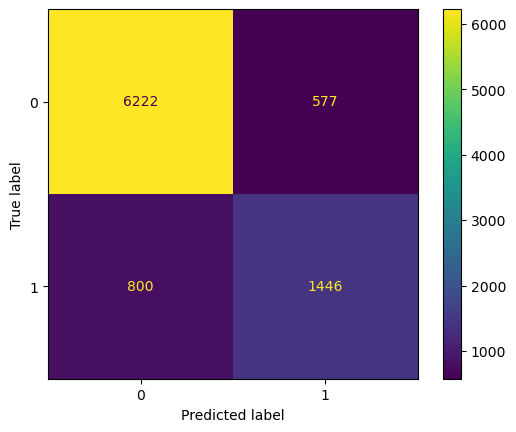

In [22]:
cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(confusion_matrix = cm).plot()
plt.show()

When looking at the confusion matrix we can see that the model does perform relatively well. We can also see that if does slightly favor predicting that someone makes less then 50k. This does make sense as a majority of the data makes less than 50k. We will need to perform further analysis to see if this is truly a problem. 

In [24]:
accuracy_score(y_test, pred)

0.8477611940298507

The model can predict the testing data with nearly 85% accuracy. This is a decent score for the model, and could improve with some tuning of the parameters.

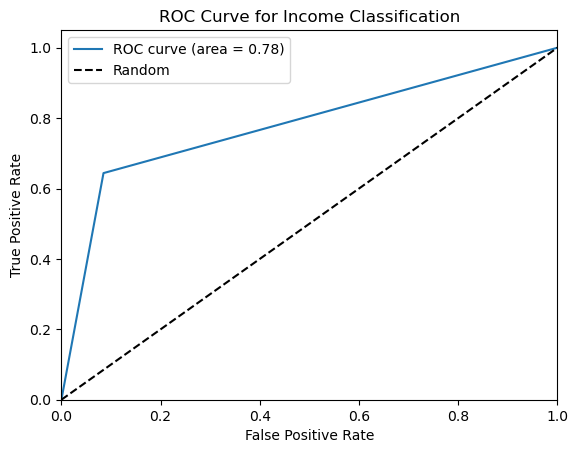

In [31]:
ppred = fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)


plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Income Classification')
plt.legend()
plt.show()

The Roc-Auc curve shows us the true positive vs the false positive rates in the model, and then the area under the curve represents the strength of the model. The goal is always to maximize the area under the curve, and to do that we must improve our true positive rate and maintain a low false positive. A good AUC score is larger than .5, as that would mean that the model performs better than randomly guessing. In this case, we can see that the optimal true positive rate is between .6 and .7 because after that the false positive rate skyrockets. We can also see that the AUC is about .78. This means the model has a good ability to differentiate between the classes, but it is not perfect.

In [34]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
score = cross_val_score(KNeighborsClassifier(n_neighbors= 5, metric = 'minkowski', p = 2),
                        X, y, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [0.84267551 0.84776119 0.84962406 0.84520124 0.84741265]
Average score: 0.85


In [36]:
kf = KFold(n_splits=5, shuffle=True, random_state=100)
score = cross_val_score(KNeighborsClassifier(n_neighbors= 5, metric = 'minkowski', p = 2),
                        X, y, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [0.84488668 0.84975124 0.85028748 0.84442724 0.8404467 ]
Average score: 0.85


KFold allows us to take small subsets, folds, of our data and then run the model on them to see if the model performs uniformly across all of the data. In this case, we will use stratified kfold as it performs better when there is a large disparity between the size of the two classification groups. It does this by maintaining the proportion of the group sizes across all folds. KFold analysis shows us that the model performs very similarly across all 5 folds. This means that the model does perform well for the given data. This remains true in standard KFold validation. This also shows that the discrepancy in group sizes is not as detrimental as we might have thought.


We have now answered both of our questions. First, we know that we can predict the income level of someone with an accuracy of about 85%. Second, we know that the model does not tend to overly favor one group over the other.

## <center> Reference
Becker, Barry and Kohavi, Ronny. (1996). Adult. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20.
    
Harrison, O. (2019, July 14). Machine learning basics with the K-nearest neighbors algorithm. Medium. https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761 